[10. 10. 10.]
[10. 10. 10.]
[10. 10. 10.]
[10. 10. 10.]
[10. 10. 10.]
[10. 10. 10.]
[10. 10. 10.]
[10. 10. 10.]


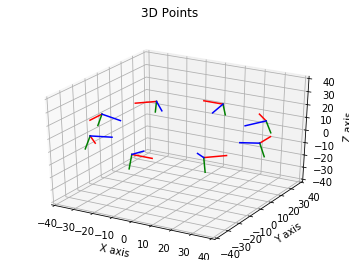

In [25]:
"""
GTSAM Copyright 2010-2018, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)
See LICENSE for the license information
A structure-from-motion problem on a simulated dataset, using smart projection factor.
Author: Duy-Nguyen Ta (C++), Frank Dellaert (Python)
"""
# pylint: disable=invalid-name, E1101

from __future__ import print_function

import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt
import numpy as np
from gtsam.symbol_shorthand import L, X
from gtsam.examples import SFMdata
from mpl_toolkits.mplot3d import Axes3D  # pylint: disable=W0611

def SFMExample_SmartFactor():
    plt.ion()

    # Define the camera calibration parameters
    K = gtsam.Cal3_S2(50.0, 50.0, 0.0, 50.0, 50.0)

    # Define the camera observation noise model
    measurement_noise = gtsam.noiseModel.Isotropic.Sigma(
        2, 1.0)  # one pixel in u and v

    # Create the set of ground-truth landmarks
    points = SFMdata.createPoints()

    # Create the set of ground-truth poses
    poses = SFMdata.createPoses(K)

    # Create a Factor Graph and Values to hold the new data
    graph = gtsam.NonlinearFactorGraph()
    initial_estimate = gtsam.Values()

    # Simulated measurements from each camera pose, adding them to the factor graph
    for point in points:

        # Every landmark represent a single landmark, we use shared pointer to init the factor, and then insert measurements
        smart_factor = gtsam.SmartProjectionPose3Factor(measurement_noise, K)

        for i, pose in enumerate(poses):
            camera = gtsam.PinholeCameraCal3_S2(pose, K)
            measurement = camera.project(point)

            # Add measurement to smart factor
            smart_factor.add(measurement, X(i))
        
        # Insert the smart factor in the graph
        graph.push_back(smart_factor)

    # Add a prior on pose x0
    # 30cm std on x,y,z 0.1 rad on roll,pitch,yaw
    pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array(
        [0.1, 0.1, 0.1, 0.3, 0.3, 0.3]))  
    graph.push_back(gtsam.PriorFactorPose3(X(0), poses[0], pose_noise))

    # Because the structure-from-motion problem has a scale ambiguity, the problem is
    # still under-constrained. Here we add a prior on the second pose x1, so this will
    # fix the scale by indicating the distance between x0 and x1.
    # Because these two are fixed, the rest of the poses will be also be fixed.
    graph.push_back(gtsam.PriorFactorPose3(X(1), poses[1], pose_noise)) # Add directly to graph
    graph.print_("Factor Graph:\n")



    # Create the initial estimate to the solution
    # Intentionally initialize the variables off from the ground truth
    delta = gtsam.Pose3(gtsam.Rot3.Rodrigues(-0.1, 0.2, 0.25), gtsam.Point3(0.05, -0.10, 0.20))
    for i, pose in enumerate(poses):
        initial_estimate.insert(X(i), pose.compose(delta))
    # Pose3 delta(Rot3::Rodrigues(-0.1, 0.2, 0.25), Point3(0.05, -0.10, 0.20));
    # for (size_t i = 0; i < poses.size(); ++i)
    # initialEstimate.insert(i, poses[i].compose(delta));
    initial_estimate.print_("Initial Estimates:\n");
    # print(initial_estimate)

    params = gtsam.LevenbergMarquardtParams()
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
    result = optimizer.optimize()
    
    # A smart factor represent the 3D point inside the factor, not as a variable.
    # The 3D position of the landmark is not explicitly calculated by the optimizer.
    # To obtain the landmark's 3D position, we use the "point" method of the smart factor.
    landmark_results = gtsam.Values()

    for j, _ in enumerate(points):
        smart = graph.at(j)
        if smart:
            # print(smart, smart.result)
            # return
            # point = smart.point(result)
            point = get_point_from_smart_factor_hack(smart)
            print(point)
            # if point:
            landmark_results.insert(j, point)
    visual_ISAM2_plot(result)
    return graph

def visual_ISAM2_plot(result):
    """
    VisualISAMPlot plots current state of ISAM2 object
    Author: Ellon Paiva
    Based on MATLAB version by: Duy Nguyen Ta and Frank Dellaert
    """

    # Declare an id for the figure
    fignum = 0

    fig = plt.figure(fignum)
    axes = fig.gca(projection='3d')
    plt.cla()

    # Plot points
    # Can't use data because current frame might not see all points
    # marginals = Marginals(isam.getFactorsUnsafe(), isam.calculateEstimate())
    # gtsam.plot_3d_points(result, [], marginals)
    gtsam_plot.plot_3d_points(fignum, result, 'rx')

    # Plot cameras
    i = 0
    while result.exists(X(i)):
        pose_i = result.atPose3(X(i))
        gtsam_plot.plot_pose3(fignum, pose_i, 10)
        i += 1

    # draw
    axes.set_xlim3d(-40, 40)
    axes.set_ylim3d(-40, 40)
    axes.set_zlim3d(-40, 40)
    plt.pause(1)


def visual_ISAM2_example():
    plt.ion()

    # Define the camera calibration parameters
    K = gtsam.Cal3_S2(50.0, 50.0, 0.0, 50.0, 50.0)

    # Define the camera observation noise model
    measurement_noise = gtsam.noiseModel.Isotropic.Sigma(
        2, 1.0)  # one pixel in u and v

    # Create the set of ground-truth landmarks
    points = SFMdata.createPoints()

    # Create the set of ground-truth poses
    poses = SFMdata.createPoses(K)

    # Create an iSAM2 object. Unlike iSAM1, which performs periodic batch steps
    # to maintain proper linearization and efficient variable ordering, iSAM2
    # performs partial relinearization/reordering at each step. A parameter
    # structure is available that allows the user to set various properties, such
    # as the relinearization threshold and type of linear solver. For this
    # example, we we set the relinearization threshold small so the iSAM2 result
    # will approach the batch result.
    parameters = gtsam.ISAM2Params()
    parameters.setRelinearizeThreshold(0.01)
    parameters.setRelinearizeSkip(1)
    isam = gtsam.ISAM2(parameters)

    # Create a Factor Graph and Values to hold the new data
    graph = gtsam.NonlinearFactorGraph()
    initial_estimate = gtsam.Values()

    #  Loop over the different poses, adding the observations to iSAM incrementally
    for i, pose in enumerate(poses):

        # Add factors for each landmark observation
        for j, point in enumerate(points):
            camera = gtsam.PinholeCameraCal3_S2(pose, K)
            measurement = camera.project(point)
            graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, X(i), L(j), K))

        # Add an initial guess for the current pose
        # Intentionally initialize the variables off from the ground truth
        initial_estimate.insert(X(i), pose.compose(gtsam.Pose3(
            gtsam.Rot3.Rodrigues(-0.1, 0.2, 0.25), gtsam.Point3(0.05, -0.10, 0.20))))

        # If this is the first iteration, add a prior on the first pose to set the
        # coordinate frame and a prior on the first landmark to set the scale.
        # Also, as iSAM solves incrementally, we must wait until each is observed
        # at least twice before adding it to iSAM.
        if i == 0:
            # Add a prior on pose x0
            pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array(
                [0.1, 0.1, 0.1, 0.3, 0.3, 0.3]))  # 30cm std on x,y,z 0.1 rad on roll,pitch,yaw
            graph.push_back(gtsam.PriorFactorPose3(X(0), poses[0], pose_noise))

            # Add a prior on landmark l0
            point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
            graph.push_back(gtsam.PriorFactorPoint3(
                L(0), points[0], point_noise))  # add directly to graph

            # Add initial guesses to all observed landmarks
            # Intentionally initialize the variables off from the ground truth
            for j, point in enumerate(points):
                initial_estimate.insert(L(j), gtsam.Point3(
                    point[0]-0.25, point[1]+0.20, point[2]+0.15))
        else:
            # Update iSAM with the new factors
            isam.update(graph, initial_estimate)
            # Each call to iSAM2 update(*) performs one iteration of the iterative nonlinear solver.
            # If accuracy is desired at the expense of time, update(*) can be called additional
            # times to perform multiple optimizer iterations every step.
            isam.update()
            current_estimate = isam.calculateEstimate()
            print("****************************************************")
            print("Frame", i, ":")
            for j in range(i + 1):
                print(X(j), ":", current_estimate.atPose3(X(j)))

            for j in range(len(points)):
                print(L(j), ":", current_estimate.atPoint3(L(j)))

            visual_ISAM2_plot(current_estimate)

            # Clear the factor graph and values for the next iteration
            graph.resize(0)
            initial_estimate.clear()

    plt.ioff()
    plt.show()

def get_point_from_smart_factor_hack(smart_factor):
    lines = s.__str__().split('\n')
    index = next(i for i, line in enumerate(lines) if line.startswith("point ="))
    return gtsam.Point3(np.array([
        float(lines[index].split("=")[1]),
        float(lines[index + 1]),
        float(lines[index + 2]),
    ]))

if __name__ == '__main__':
    # visual_ISAM2_example()
    SFMExample_SmartFactor()

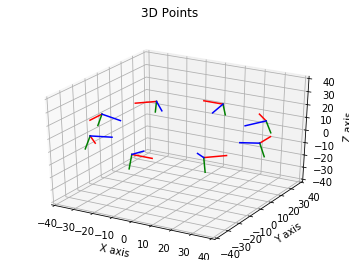

In [2]:
g = SFMExample_SmartFactor()

In [3]:
s= g.at(0)

array([10., 10., 10.])